In [1]:
from __future__ import division, print_function

import numpy as np
import pandas as pd
from scipy import optimize
from scipy.stats import rankdata

import pymc3 as mc

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
import theano.tensor as t

def tdot(x,b):
    return t.dot(x,b)

In [4]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
   assert( len(actual) == len(pred) )
   all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
   all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
   totalLosses = all[:,0].sum()
   giniSum = all[:,0].cumsum().sum() / totalLosses
   giniSum -= (len(actual) + 1) / 2.
   return giniSum / len(actual)
 
def gini_normalized(a, p):
 return gini(a, p) / gini(a, a)

In [5]:
train = pd.read_csv('train.csv', index_col='Id')
test = pd.read_csv('test.csv', index_col='Id')

In [6]:
print(train.shape)
# train = train.iloc[:1000,:]
print(train.shape)

(50999, 33)
(50999, 33)


In [7]:
train.head()

,Hazard,T1_V1,T1_V2,T1_V3,T1_V4,T1_V5,T1_V6,T1_V7,T1_V8,T1_V9,...,T2_V6,T2_V7,T2_V8,T2_V9,T2_V10,T2_V11,T2_V12,T2_V13,T2_V14,T2_V15
Id,,,,,,,,,,,,,,,,,,,,,
1,1,15,3,2,N,B,N,B,B,D,...,2,37,1,11,6,Y,N,E,2,2
2,4,16,14,5,H,B,N,B,B,C,...,2,22,1,18,5,Y,Y,E,2,1
3,1,10,10,5,N,K,N,B,B,E,...,6,37,2,14,6,Y,Y,E,6,1
4,1,18,18,5,N,K,N,B,B,E,...,2,25,1,1,6,Y,N,C,2,6
5,1,13,19,5,N,H,N,B,B,E,...,1,22,1,2,7,N,N,E,1,1


In [8]:
y = train['Hazard'].astype(np.float32)

In [9]:
T1_V1 = train['T1_V1'].astype(np.float32)
T1_V2 = train['T1_V2'].astype(np.float32)
T1_V3 = train['T1_V3'].astype(np.float32)
T1_V4 = pd.get_dummies(train['T1_V4']).astype(np.float32)
T1_V5 = pd.get_dummies(train['T1_V5']).astype(np.float32)
T1_V6 = train['T1_V6'].apply(lambda x: 1 if x=='Y' else 0).astype(np.float32)
T1_V7 = pd.get_dummies(train['T1_V7']).astype(np.float32)
T1_V8 = pd.get_dummies(train['T1_V8']).astype(np.float32)
T1_V9 = pd.get_dummies(train['T1_V9']).astype(np.float32)
T1_V11 = pd.get_dummies(train['T1_V11']).astype(np.float32)
T1_V12 = pd.get_dummies(train['T1_V12']).astype(np.float32)
T1_V14 = train['T1_V14'].astype(np.float32)
T1_V15 = pd.get_dummies(train['T1_V15']).astype(np.float32)
T1_V16 = pd.get_dummies(train['T1_V16']).astype(np.float32)
T1_V17 = train['T1_V17'].apply(lambda x: 1 if x=='Y' else 0).astype(np.float32)

In [24]:
T2_V1 = pd.get_dummies(train['T2_V1']).astype(np.float32)
T2_V2 = pd.get_dummies(train['T2_V2']).astype(np.float32)
T2_V3 = train['T2_V3'].apply(lambda x: 1 if x=='Y' else 0).astype(np.float32)
T2_V4 = pd.get_dummies(train['T2_V4']).astype(np.float32)
T2_V5 = pd.get_dummies(train['T2_V5']).astype(np.float32)
T2_V6 = pd.get_dummies(train['T2_V6']).astype(np.float32)
T2_V8 = pd.get_dummies(train['T2_V8']).astype(np.float32)
T2_V9 = train['T2_V9'].astype(np.float32)
T2_V11 = train['T2_V11'].apply(lambda x: 1 if x=='Y' else 0).astype(np.float32)
T2_V12 = train['T2_V12'].apply(lambda x: 1 if x=='Y' else 0).astype(np.float32)
T2_V13 = pd.get_dummies(train['T2_V13']).astype(np.float32)
T2_V14 = pd.get_dummies(train['T2_V14']).astype(np.float32)
train.loc[train['T2_V15']==12, 'T2_V15'] = 4.5
T2_V15 = train['T2_V15'].astype(np.float32)

In [37]:
T1_V1_T1_V2  = (T1_V1 * T1_V2)
T1_V1_T2_V15 = (T1_V1 * T2_V15)
T1_V2_T2_V15 = (T1_V2 * T2_V15)
T1_V1_T1_V8 = T1_V1[:,np.newaxis]*T1_V8

### Interactions

In [39]:
# Get all possible interactions in Train and Test
T2_V1_T2_V2_train = set(train['T2_V1'].apply(lambda x: 'A'+str(x)) + train['T2_V2'].apply(lambda x: 'B'+str(x)))
T2_V1_T2_V2_test = set(test['T2_V1'].apply(lambda x: 'A'+str(x)) + test['T2_V2'].apply(lambda x: 'B'+str(x)))

# Only keep those found in both
T2_V1_T2_V2_both = frozenset(T2_V1_T2_V2_train & T2_V1_T2_V2_test)

print(len(T2_V1_T2_V2_train))
print(len(T2_V1_T2_V2_test))
print(len(T2_V1_T2_V2_both))

T2_V1_T2_V2 = pd.DataFrame(index=train.index, columns=T2_V1_T2_V2_both, data=0)

for r in train.index:
    interaction = 'A'+str(train.loc[r, 'T2_V1']) +  'B'+str(train.loc[r, 'T2_V2'])
    if interaction in T2_V1_T2_V2_both:
        T2_V1_T2_V2.loc[r, interaction] = 1


# only keep those with at least 10 instances
drop_list = list(T2_V1_T2_V2.sum()[T2_V1_T2_V2.sum()<10].index)

print(T2_V1_T2_V2.shape)
T2_V1_T2_V2.drop(drop_list, axis=1, inplace=True)
print(T2_V1_T2_V2.shape)


2657
2677
2319
(50999, 2319)
(50999, 1662)


In [236]:
y_log = y.apply(np.log)

In [87]:
with mc.Model() as model:
    
    b_0     = mc.Normal('b_0',     mu=0, sd=1)
      
    b_T1_V1 = mc.Normal('b_T1_V1', mu=0, sd=1)
    b_T1_V2 = mc.Normal('b_T1_V2', mu=0, sd=1)
    b_T1_V3 = mc.Normal('b_T1_V3', mu=0, sd=1)    
    b_T1_V4 = mc.Normal('b_T1_V4', mu=0, sd=1, shape=T1_V4.shape[1])      
#     b_T1_V5 = mc.Normal('b_T1_V5', mu=0, sd=1, shape=T1_V5.shape[1])        
    b_T1_V6 = mc.Normal('b_T1_V6', mu=0, sd=1) 
#     b_T1_V7 = mc.Normal('b_T1_V7', mu=0, sd=1, shape=T1_V7.shape[1])        
    b_T1_V8 = mc.Normal('b_T1_V8', mu=0, sd=1, shape=T1_V8.shape[1])    
#     b_T1_V9 = mc.Normal('b_T1_V9', mu=0, sd=1, shape=T1_V9.shape[1])   
#     b_T1_V11 = mc.Normal('b_T1_V11', mu=0, sd=1, shape=T1_V11.shape[1])     
#     b_T1_V12 = mc.Normal('b_T1_V12', mu=0, sd=1, shape=T1_V12.shape[1])    
    b_T1_V14 = mc.Normal('b_T1_V14', mu=0, sd=1)     
    b_T1_V15 = mc.Normal('b_T1_V15', mu=0, sd=1, shape=T1_V15.shape[1])    
#     b_T1_V16 = mc.Normal('b_T1_V16', mu=0, sd=1, shape=T1_V16.shape[1])        
    b_T1_V17 = mc.Normal('b_T1_V17', mu=0, sd=1) 
    
    b_T2_V1 = mc.Normal('b_T2_V1', mu=0, sd=1, shape=T2_V1.shape[1])      
    b_T2_V2 = mc.Normal('b_T2_V2', mu=0, sd=1, shape=T2_V2.shape[1])   
    b_T2_V3 = mc.Normal('b_T2_V3', mu=0, sd=1) 
#     b_T2_V4 = mc.Normal('b_T2_V4', mu=0, sd=1, shape=T2_V4.shape[1])      
#     b_T2_V5 = mc.Normal('b_T2_V5', mu=0, sd=1, shape=T2_V5.shape[1])     
#     b_T2_V6 = mc.Normal('b_T2_V6', mu=0, sd=1, shape=T2_V6.shape[1])
#     b_T2_V8 = mc.Normal('b_T2_V8', mu=0, sd=1, shape=T2_V8.shape[1])    
    b_T2_V9 = mc.Normal('b_T2_V9', mu=0, sd=1)     
    b_T2_V11 = mc.Normal('b_T2_V11', mu=0, sd=1)      
    b_T2_V12 = mc.Normal('b_T2_V12', mu=0, sd=1)     
#     b_T2_V13 = mc.Normal('b_T2_V13', mu=0, sd=1, shape=T2_V13.shape[1]) 
#     b_T2_V14 = mc.Normal('b_T2_V14', mu=0, sd=1, shape=T2_V14.shape[1])     
    b_T2_V15 = mc.Normal('b_T2_V15', mu=0, sd=1)      

    b_T1_V1_T1_V2 = mc.Normal('b_T1_V1_T1_V2', mu=0, sd=1)
    b_T1_V1_T2_V15 = mc.Normal('b_T1_V1_T2_V15', mu=0, sd=1)
    b_T1_V2_T2_V15 = mc.Normal('b_T1_V2_T2_V15', mu=0, sd=1)
    
#     b_T1_V1_T1_V8 = mc.Normal('b_T1_V1_T1_V8', mu=0, sd=1, shape=T1_V8.shape[1])   
    
#     b_T2_V1_T2_V2 = mc.Normal('b_T2_V1_T2_V2', mu=0, sd=1, shape=T2_V1_T2_V2.shape[1])
    
    # Try modeling mu as lam ~ Exp()
    # Add ^2 and interactions of important variables
    
    mu = ( b_0
          + tdot(T1_V1, b_T1_V1)
          + tdot(T1_V2, b_T1_V2)
          + tdot(T1_V3, b_T1_V3)
          + tdot(T1_V4, b_T1_V4) 
#           + tdot(T1_V5, b_T1_V5)
          + tdot(T1_V6, b_T1_V6)   # Doesn't appear to do anything
#           + tdot(T1_V7, b_T1_V7)          
          + tdot(T1_V8, b_T1_V8)          
#           + tdot(T1_V9, b_T1_V9) 
#           + tdot(T1_V11, b_T1_V11)          
#           + tdot(T1_V12, b_T1_V12)           
          + tdot(T1_V14, b_T1_V14)
          + tdot(T1_V15, b_T1_V15)           
#           + tdot(T1_V16, b_T1_V16)
          + tdot(T1_V17, b_T1_V17)
          
          + tdot(T2_V1, b_T2_V1)
          + tdot(T2_V2, b_T2_V2)          
          + tdot(T2_V3, b_T2_V3)
#           + tdot(T2_V4, b_T2_V4)    
#           + tdot(T2_V5, b_T2_V5)
#           + tdot(T2_V6, b_T2_V6) 
#           + tdot(T2_V8, b_T2_V8) 
          + tdot(T2_V9, b_T2_V9) 
          + tdot(T2_V11, b_T2_V11) 
          + tdot(T2_V12, b_T2_V12)           
#           + tdot(T2_V13, b_T2_V13)              
#           + tdot(T2_V14, b_T2_V14)
          + tdot(T2_V15, b_T2_V15)          
          
          + tdot(T1_V1_T1_V2,  b_T1_V1_T1_V2)
          + tdot(T1_V1_T2_V15, b_T1_V1_T2_V15)
          + tdot(T1_V2_T2_V15, b_T1_V2_T2_V15)
          
#           + tdot(T1_V1_T1_V8, b_T1_V1_T1_V8)
          
#           + tdot(T2_V1_T2_V2, b_T2_V1_T2_V2)
         )
    
    s = mc.HalfNormal('s', 1)
    
#     haz = mc.NegativeBinomial('haz', mu=mu, alpha=s, observed=y)
    haz = mc.Normal('haz', mu=mu, sd=s, observed=y_log)
    
    start = mc.find_MAP(model=model, fmin=optimize.fmin_powell)
#     C = mc.approx_hessian(model.test_point)
    step = mc.NUTS(scaling=start)    
    trace = mc.sample(200, step, start=start, random_seed=27)
    
    # Try GLM and approximate hessian
    # Do a prediction - complete the pipeline - then improve the model

 [-----------------100%-----------------] 201 of 200 complete in 1793.9 sec

In [88]:
# y_log = y.apply(np.log)

# glm = mc.glm.glm
# Family = mc.glm.families.Poisson

# data = pd.concat([y,T1_V1,T1_V2,T1_V8], axis=1)

# with mc.Model() as model:
    
#     glm('Hazard ~ T1_V1 + T1_V2 + A + B + C + D', data, family=Family())

#     start = mc.find_MAP(model=model, fmin=optimize.fmin_powell)
# #     C = mc.approx_hessian(model.test_point)
#     step = mc.NUTS(scaling=start)    
#     trace = mc.sample(200, step)

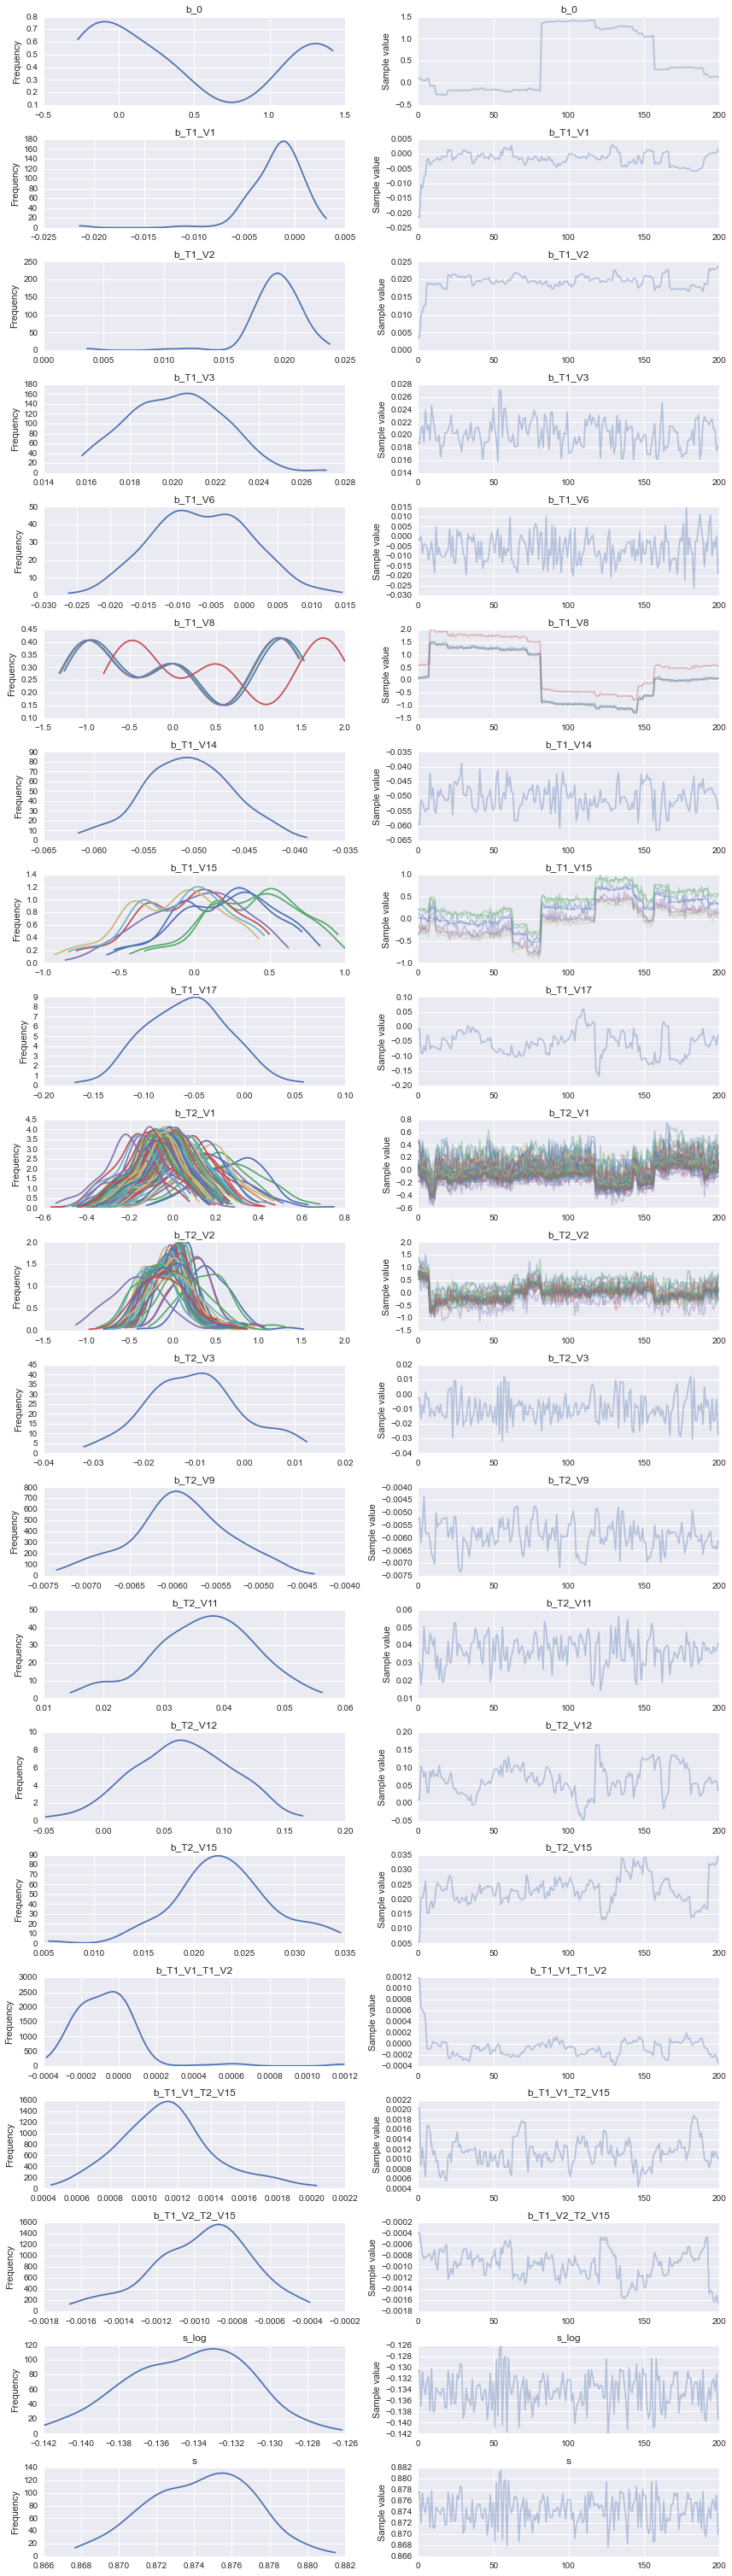

In [89]:
mc.traceplot(trace);

```
NegativeBinomial
T1_V1             : 0.0695   *
T1_V2             : 0.1417   *
T1_V3             : 0.1533
T1_V6             : 0.1527
T1_V14            : 0.1652
T1_V17            : 0.1654
T2_V3             : 0.1646 < remove?
T2_V9             : 0.1733
T2_V11            : 0.1740
T2_V12            : 0.1743
T2_V15            : 0.1869   *
T1_V1_T1_V2       : 0.1881
T1_V1_T2_V15      : 0.1901
T1_V2_T2_V15      : 0.1909  (0.1901 using log-y and Normal)

T1_V8             : 0.2266
T1_V1_T1_V8       : 0.2264 << removed
T2_V1             : 0.2397
T2_V2             : 0.2488
T1_V15            : 0.2672
T1_V4             :











```

In [90]:
mu = ( trace['b_0'][np.newaxis, :]
      + np.dot(T1_V1[:,np.newaxis], trace['b_T1_V1'][np.newaxis,:])     
      + np.dot(T1_V2[:,np.newaxis], trace['b_T1_V2'][np.newaxis,:])   
      + np.dot(T1_V3[:,np.newaxis], trace['b_T1_V3'][np.newaxis,:])   
      + np.dot(T1_V4, trace['b_T1_V4'].T)  
#       + np.dot(T1_V5, trace['b_T1_V5'].T)  
      + np.dot(T1_V6[:,np.newaxis], trace['b_T1_V6'][np.newaxis,:])      
#       + np.dot(T1_V7, trace['b_T1_V7'].T)  
      + np.dot(T1_V8, trace['b_T1_V8'].T)   
#       + np.dot(T1_V9, trace['b_T1_V9'].T)  
#       + np.dot(T1_V11, trace['b_T1_V11'].T)  
#       + np.dot(T1_V12, trace['b_T1_V12'].T)        
      + np.dot(T1_V14[:,np.newaxis], trace['b_T1_V14'][np.newaxis,:])           
      + np.dot(T1_V15, trace['b_T1_V15'].T)  
#       + np.dot(T1_V16, trace['b_T1_V16'].T)        
      + np.dot(T1_V17[:,np.newaxis], trace['b_T1_V17'][np.newaxis,:])     

      
      + np.dot(T2_V1, trace['b_T2_V1'].T)  
      + np.dot(T2_V2, trace['b_T2_V2'].T) 
      + np.dot(T2_V3[:,np.newaxis], trace['b_T2_V3'][np.newaxis,:]) 
#       + np.dot(T2_V4, trace['b_T2_V4'].T)  
#       + np.dot(T2_V5, trace['b_T2_V5'].T)       
#       + np.dot(T2_V6, trace['b_T2_V6'].T)         
#       + np.dot(T2_V8, trace['b_T2_V8'].T)   
      + np.dot(T2_V9[:,np.newaxis], trace['b_T2_V9'][np.newaxis,:])       
      + np.dot(T2_V11[:,np.newaxis], trace['b_T2_V11'][np.newaxis,:]) 
      + np.dot(T2_V12[:,np.newaxis], trace['b_T2_V12'][np.newaxis,:])       
#       + np.dot(T2_V13, trace['b_T2_V13'].T)       
#       + np.dot(T2_V14, trace['b_T2_V14'].T)   
      + np.dot(T2_V15[:,np.newaxis], trace['b_T2_V15'][np.newaxis,:])       
      
      + (trace['b_T1_V1_T1_V2'][np.newaxis, :]  * (T1_V1 * T1_V2 )[:,np.newaxis])
      + (trace['b_T1_V1_T2_V15'][np.newaxis, :] * (T1_V1 * T2_V15)[:,np.newaxis])
      + (trace['b_T1_V2_T2_V15'][np.newaxis, :] * (T1_V2 * T2_V15)[:,np.newaxis])

#       + np.dot(T1_V1_T1_V8, trace['b_T1_V1_T1_V8'].T)
      
      
#       + np.dot(T2_V1_T2_V2, trace['b_T2_V1_T2_V2'].T)
     )

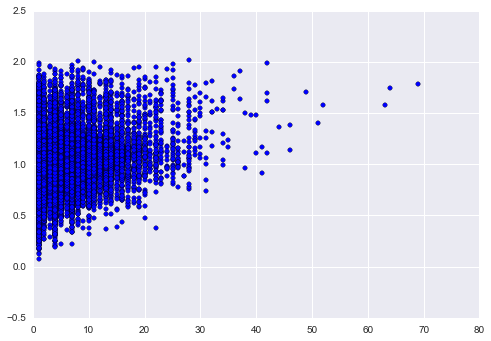

In [91]:
plt.scatter(y,np.percentile(mu, 50, axis=1))
plt.xlim((0,80))
# plt.ylim((0,80))
plt.show()

```
0.5606 - Lognormal -  87 / 100
0.6143 - Poisson   - 432 / 100
0.4965 - Normal    -  35 / 100
0.6536 - NegBin    - 764 / 100
```

In [92]:
print('{:0.4f}'.format(gini_normalized(y,mu.min(1))))
print('{:0.4f}'.format(gini_normalized(y,np.percentile(mu, 10, axis=1))))
print('{:0.4f}'.format(gini_normalized(y,np.percentile(mu, 25, axis=1))))
print('{:0.4f}'.format(gini_normalized(y,np.percentile(mu, 50, axis=1))))
print('{:0.4f}'.format(gini_normalized(y,np.percentile(mu, 75, axis=1))))
print('{:0.4f}'.format(gini_normalized(y,np.percentile(mu, 90, axis=1))))
print('{:0.4f}'.format(gini_normalized(y,mu.max(1))))

0.2589
0.2653
0.2665
0.2672
0.2671
0.2663
0.2624


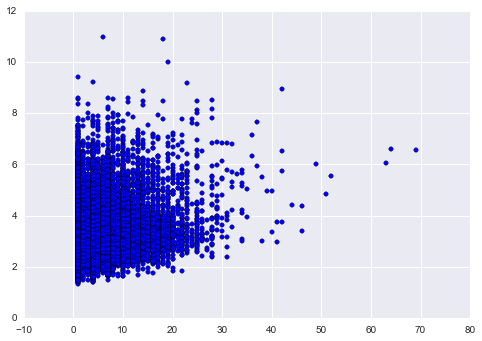

In [93]:
plt.scatter(y, np.exp(mu.max(1)));

### Predict on Test Set

In [101]:
T1_V1 = test['T1_V1'].astype(np.float32)
T1_V2 = test['T1_V2'].astype(np.float32)
T1_V3 = test['T1_V3'].astype(np.float32)
T1_V4 = pd.get_dummies(test['T1_V4']).astype(np.float32)
T1_V5 = pd.get_dummies(test['T1_V5']).astype(np.float32)
T1_V6 = test['T1_V6'].apply(lambda x: 1 if x=='Y' else 0).astype(np.float32)
T1_V7 = pd.get_dummies(test['T1_V7']).astype(np.float32)
T1_V8 = pd.get_dummies(test['T1_V8']).astype(np.float32)
T1_V9 = pd.get_dummies(test['T1_V9']).astype(np.float32)
T1_V11 = pd.get_dummies(test['T1_V11']).astype(np.float32)
T1_V12 = pd.get_dummies(test['T1_V12']).astype(np.float32)
T1_V14 = test['T1_V14'].astype(np.float32)
T1_V15 = pd.get_dummies(test['T1_V15']).astype(np.float32)
T1_V16 = pd.get_dummies(test['T1_V16']).astype(np.float32)
T1_V17 = test['T1_V17'].apply(lambda x: 1 if x=='Y' else 0).astype(np.float32)

In [102]:
T2_V1 = pd.get_dummies(test['T2_V1']).astype(np.float32)
T2_V2 = pd.get_dummies(test['T2_V2']).astype(np.float32)
T2_V3 = test['T2_V3'].apply(lambda x: 1 if x=='Y' else 0).astype(np.float32)
T2_V4 = pd.get_dummies(test['T2_V4']).astype(np.float32)
T2_V5 = pd.get_dummies(test['T2_V5']).astype(np.float32)
T2_V6 = pd.get_dummies(test['T2_V6']).astype(np.float32)
T2_V8 = pd.get_dummies(test['T2_V8']).astype(np.float32)
T2_V9 = test['T2_V9'].astype(np.float32)
T2_V11 = test['T2_V11'].apply(lambda x: 1 if x=='Y' else 0).astype(np.float32)
T2_V12 = test['T2_V12'].apply(lambda x: 1 if x=='Y' else 0).astype(np.float32)
T2_V13 = pd.get_dummies(test['T2_V13']).astype(np.float32)
T2_V14 = pd.get_dummies(train['T2_V14']).astype(np.float32)
test.loc[test['T2_V15']==12, 'T2_V15'] = 4.5
T2_V15 = test['T2_V15'].astype(np.float32)

In [103]:
T1_V1_T1_V2  = (T1_V1 * T1_V2)
T1_V1_T2_V15 = (T1_V1 * T2_V15)
T1_V2_T2_V15 = (T1_V2 * T2_V15)
T1_V1_T1_V8 = T1_V1[:,np.newaxis]*T1_V8

In [104]:
mu = ( trace['b_0'][np.newaxis, :]
      + np.dot(T1_V1[:,np.newaxis], trace['b_T1_V1'][np.newaxis,:])     
      + np.dot(T1_V2[:,np.newaxis], trace['b_T1_V2'][np.newaxis,:])   
      + np.dot(T1_V3[:,np.newaxis], trace['b_T1_V3'][np.newaxis,:])   
      + np.dot(T1_V4, trace['b_T1_V4'].T)  
#       + np.dot(T1_V5, trace['b_T1_V5'].T)  
      + np.dot(T1_V6[:,np.newaxis], trace['b_T1_V6'][np.newaxis,:])      
#       + np.dot(T1_V7, trace['b_T1_V7'].T)  
      + np.dot(T1_V8, trace['b_T1_V8'].T)   
#       + np.dot(T1_V9, trace['b_T1_V9'].T)  
#       + np.dot(T1_V11, trace['b_T1_V11'].T)  
#       + np.dot(T1_V12, trace['b_T1_V12'].T)        
      + np.dot(T1_V14[:,np.newaxis], trace['b_T1_V14'][np.newaxis,:])           
      + np.dot(T1_V15, trace['b_T1_V15'].T)  
#       + np.dot(T1_V16, trace['b_T1_V16'].T)        
      + np.dot(T1_V17[:,np.newaxis], trace['b_T1_V17'][np.newaxis,:])     

      
      + np.dot(T2_V1, trace['b_T2_V1'].T)  
      + np.dot(T2_V2, trace['b_T2_V2'].T) 
      + np.dot(T2_V3[:,np.newaxis], trace['b_T2_V3'][np.newaxis,:]) 
#       + np.dot(T2_V4, trace['b_T2_V4'].T)  
#       + np.dot(T2_V5, trace['b_T2_V5'].T)       
#       + np.dot(T2_V6, trace['b_T2_V6'].T)         
#       + np.dot(T2_V8, trace['b_T2_V8'].T)   
      + np.dot(T2_V9[:,np.newaxis], trace['b_T2_V9'][np.newaxis,:])       
      + np.dot(T2_V11[:,np.newaxis], trace['b_T2_V11'][np.newaxis,:]) 
      + np.dot(T2_V12[:,np.newaxis], trace['b_T2_V12'][np.newaxis,:])       
#       + np.dot(T2_V13, trace['b_T2_V13'].T)       
#       + np.dot(T2_V14, trace['b_T2_V14'].T)   
      + np.dot(T2_V15[:,np.newaxis], trace['b_T2_V15'][np.newaxis,:])       
      
      + (trace['b_T1_V1_T1_V2'][np.newaxis, :]  * (T1_V1 * T1_V2 )[:,np.newaxis])
      + (trace['b_T1_V1_T2_V15'][np.newaxis, :] * (T1_V1 * T2_V15)[:,np.newaxis])
      + (trace['b_T1_V2_T2_V15'][np.newaxis, :] * (T1_V2 * T2_V15)[:,np.newaxis])

#       + np.dot(T1_V1_T1_V8, trace['b_T1_V1_T1_V8'].T)
      
      
#       + np.dot(T2_V1_T2_V2, trace['b_T2_V1_T2_V2'].T)
     )

In [105]:
model_number = 1
submission = pd.read_csv('sample_submission.csv', index_col='Id')
submission.Hazard = np.percentile(mu, 50, axis=1)
submission.to_csv('submissions/pymc_{:04d}.csv'.format(model_number))